# Test suite for env_template_sa

In [1]:
from marketsai.mon_policy.env_mon_policy import MonPolicy
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import time
# environment config
n_firms = 2
n_inds = 2
env_config = {
    "horizon": 200,
    "n_inds": n_inds,
    "n_firms": n_firms,
    "eval_mode": False,
    "noagg_mode": False,
    "analysis_mode": False,
    "seed_eval": 2000,
    "seed_noagg": 2500,
    "seed_analisys": 3000,
    "info_mode": False,
    "markup_max": 2,
    "markup_start": 1.3,
    "rew_mean": 0,
    "rew_std": 1,
    "parameters": {
        "beta": 0.95 ** (1 / 12),
        "log_g_bar": 0.0021,
        "rho_g": 0.61,
        "sigma_g": 0.0019,
        "theta": 1.5,
        "eta": 10.5,
        "menu_cost": 0.17,
        "sigma_z": 0.038,
    },
}

def process_rewards(r, BETA):
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, len(r))):
        running_add = running_add * BETA + r[t]
        discounted_r[t] = running_add
    return discounted_r[0]

In [ ]:
# validate spaces
env = MonPolicy(env_config)
print(
    "action space type:",
    type(env.action_space["firm_0"]["move_prob"].sample()),type(env.action_space["firm_0"]["reset_markup"].sample()),
    "action space sample:",
   {"move_prob": env.action_space["firm_0"]["move_prob"].sample(), "reset_markup": env.action_space["firm_0"]["reset_markup"].sample()},
)
print(
    "obs space type:",
    type(env.observation_space["firm_0"].sample()),
    "obs space sample:",
    env.observation_space["firm_0"].sample(),
)
obs_init = env.reset()
print("inital observation", obs_init)
print(
    "obs_init contained in obs_space?",
    env.observation_space["firm_0"].contains(obs_init["firm_0"]),
)
if not env.observation_space["firm_0"].contains(obs_init["firm_0"]):
    print(obs_init)
print(
    "random number in [-1,1] contained in action_space?",
    env.action_space["firm_0"]["reset_markup"].contains(np.array([np.random.uniform(-1, 1)])),
)
obs, rew, done, info = env.step({f"firm_{i}": {"move_prob": env.action_space["firm_0"]["move_prob"].sample(),"reset_markup": env.action_space["firm_0"]["reset_markup"].sample()} for i in range(env.n_agents)})
print(
    "obs after step contained in obs space?",
    env.observation_space["firm_0"].contains(obs["firm_0"]),
        )

In [ ]:
data_timing = {
    "time_init": [],
    "time_reset": [],
    "time_step": [],
    "max_passthrough": [],
}

time_preinit = time.time()
env = MonPolicy(env_config=env_config)
time_postinit = time.time()
env.reset()
time_postreset = time.time()
obs, rew, done, info = env.step({f"firm_{i}": {"move_prob": env.action_space["firm_0"]["move_prob"].sample(),"reset_markup": env.action_space["firm_0"]["reset_markup"].sample()} for i in range(env.n_agents)})
time_poststep = time.time()

data_timing["time_init"].append((time_postinit - time_preinit) * 1000)
data_timing["time_reset"].append((time_postreset - time_postinit) * 1000)
data_timing["time_step"].append((time_poststep - time_postreset) * 1000)
data_timing["max_passthrough"].append(1 / (time_poststep - time_postreset))
print(data_timing)

In [ ]:
# simulate
SIMUL_PERIODS = 100000
env = MonPolicy(env_config=env_config)
mu_stats, rew_stats, g_stats= env.random_sample(SIMUL_PERIODS)
print("[mu_max, mu_min, mu_mean, mu_std]:", mu_stats, 
    "\n" + "[rew_max, rew_min, rew_mean, rew_std:]", rew_stats,
    "\n" + "[g_max, g_min, g_mean, g_std:]", g_stats,
    "\n" + "[rew_disc_max, rew_disc_min, rew_disc_mean, rew_disc_std:]", 0,)

/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Discounted Rewards 7.277238835552248 
mu_stats: [2.162893226604803, 0.9661138090318733, 1.4646968150989073, 0.27771553050823233] 
reward_stats: [0.33034911876276407, -0.11870982845924355, 0.08320951931580846, 0.10214055094507622]


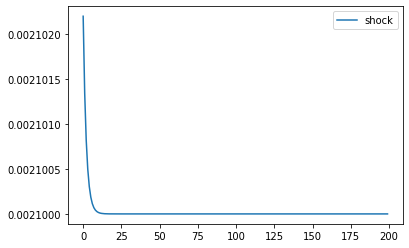

In [2]:
# run analysis mode
env_config_analysis = env_config.copy()
env_config_analysis["analysis_mode"] = True
env = MonPolicy(env_config=env_config_analysis)
mu_list = []
rew_list = []
shock_list = []

env.reset()
for t in range(200):
    if t % 200 == 0:
        obs = env.reset()
    obs, rew, done, info = env.step({f"firm_{i}": {"move_prob": env.action_space["firm_0"]["move_prob"].sample(),"reset_markup": env.action_space["firm_0"]["reset_markup"].sample()} for i in range(env.n_agents)})
    shock_list.append(env.log_g)
    mu_list.append(env.mu_ij[0])
    rew_list.append(env.profits[0])
disc_rew = process_rewards(rew_list,0.99)
print("Discounted Rewards", disc_rew,
    "\n"+"mu_stats:",
    [
        np.max(mu_list),
        np.min(mu_list),
        np.mean(mu_list),
        np.std(mu_list),
    ],
    "\n"+"reward_stats:",
    [np.max(rew_list), np.min(rew_list), np.mean(rew_list), np.std(rew_list)],
)
plt.plot(shock_list)
plt.legend(["shock"])
plt.show()

In [ ]:
# run evaluation mode
env_config_eval = env_config.copy()
env_config_eval["eval_mode"] = True
env_config_eval["simul_mode"] = True
env = MonPolicy(env_config=env_config_eval)
k_list = []
rew_list = []
shock_list = []

env.reset()
for t in range(200):
    if t % 200 == 0:
        obs = env.reset()
    obs, rew, done, info = env.step({f"firm_{i}": {"move_prob": env.action_space["firm_0"]["move_prob"].sample(),"reset_markup": env.action_space["firm_0"]["reset_markup"].sample()} for i in range(env.n_agents)})
    shock_list.append(env.log_g)
    mu_list.append(env.mu_ij[0])
    rew_list.append(env.profits[0])
disc_rew = process_rewards(rew_list,0.99)
print("Discounted Rewards", disc_rew,
    "\n"+"cmu_stats:",
    [
        np.max(mu_list),
        np.min(mu_list),
        np.mean(mu_list),
        np.std(mu_list),
    ],
    "\n"+"reward_stats:",
    [np.max(rew_list), np.min(rew_list), np.mean(rew_list), np.std(rew_list)],
)
plt.plot(shock_list)
plt.legend(["shock"])
plt.show()